In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from gcdyn import bdms, mutators, poisson

# Single-type simulation

In [2]:
expected_ntips_obs = 100
expected_ntips_unobs = 1000

λ = 1
t = np.log(expected_ntips_unobs)/λ
dt = .01

rho0 = min(expected_ntips_obs / np.exp(λ*t), 1)
print(f"Sampling probability = {rho0}")
print(f"Expected (observed) number of tips = {rho0 * np.exp(λ*t)}")
print(f"Expected (unobserved) number of tips = {np.exp(λ*t)}")

Sampling probability = 0.10000000000000002
Expected (observed) number of tips = 100.0
Expected (unobserved) number of tips = 999.9999999999998


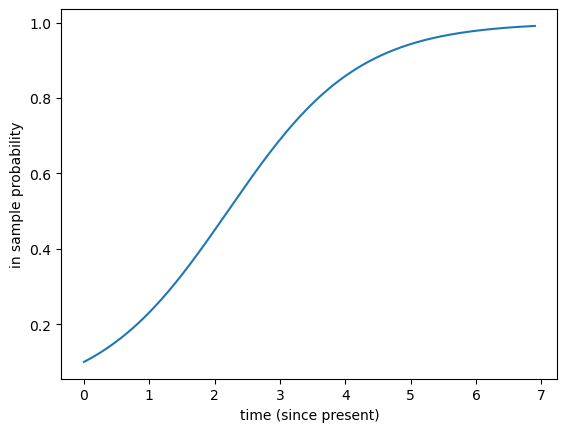

In [3]:
ts = np.arange(0,t,dt)
Es = np.zeros(ts.shape)

Es[0] = 1 - rho0
for i in range(1,len(ts)):
    Es[i] = Es[i-1] + dt*λ*(Es[i-1]**2-Es[i-1])
    
plt.plot(ts,1-Es);
plt.ylabel("in sample probability");
plt.xlabel("time (since present)");

In [4]:
def Efnc(t):
    return np.interp(t,ts,Es)

def modulation(λ, x, t):
    # return λ 
    return λ * (1-Efnc(t))

In [5]:
birth_rate_modulated = poisson.ModulatedRateResponse(
    poisson.ConstantResponse(λ),
    modulation
)
birth_rate_base = poisson.ConstantResponse(λ)
death_rate = poisson.ConstantResponse(0.0)
mutation_rate = poisson.ConstantResponse(0.0)

In [6]:
mutator = mutators.DiscreteMutator(state_space=[0],transition_matrix=np.matrix([1]))

In [27]:
# modulated simulation
tip_counts_modulated = []
times_modulated = []
error_seeds_modulated = []
for i in range(50):
    rng = np.random.default_rng(seed=i)
    try:
        start_time = time.time()
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            t,
            birth_response=birth_rate_modulated,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=1,
            capacity=10000,
            birth_mutations=False,
            seed=rng,
        )
        times_modulated = times_modulated + [time.time() - start_time]
        print(f"try {i + 1} succeeded, tip count: {len(tree)}",end="\r")
        tip_counts_modulated = tip_counts_modulated + [len(tree)]
    except:
        error_seeds_modulated = error_seeds_modulated + [i]
        continue

Δt=1.7443507417499384, Λ=1.7191395895340535, τ=1.7191341927370476, λ=0.9911145068302577


In [28]:
# full simulation
tip_counts_pruned = []
tip_counts_full = []
times_base = []
error_seeds_base = []
for i in range(50):
    rng = np.random.default_rng(seed=i)
    try:
        start_time = time.time()
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            t,
            birth_response=birth_rate_base,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=1,
            capacity=10000,
            birth_mutations=False,
            seed=rng,
        )
        tip_counts_full = tip_counts_full + [len(tree)]
        tree.sample_survivors(p=rho0)
        tree.prune()
        print(f"try {i + 1} succeeded, tip count: {len(tree)}",end="\r")
        tip_counts_pruned = tip_counts_pruned + [len(tree)]
        times_base = times_base + [time.time() - start_time]
    except:
        error_seeds_base = error_seeds_base + [i]
        continue

In [34]:
print(tip_counts_modulated)
print(tip_counts_pruned)
print(tip_counts_full)

[73, 62, 186, 194, 8, 33, 45, 112, 70, 4, 67, 99, 123, 91, 4, 8, 153, 44, 176, 128, 187, 152, 226, 180, 7, 97, 37, 73, 58, 190, 16, 65, 125, 71, 170, 113, 48, 19, 202, 60, 1, 18, 91, 20, 46, 57, 20, 3, 39]
[83, 70, 192, 217, 6, 34, 58, 99, 99, 4, 74, 103, 116, 97, 3, 3, 142, 40, 161, 119, 192, 147, 255, 165, 6, 98, 25, 90, 62, 221, 14, 57, 111, 183, 66, 192, 122, 44, 8, 233, 34, 1, 24, 95, 20, 35, 57, 21, 1, 34]
[827, 692, 1846, 2108, 51, 336, 464, 971, 760, 48, 658, 1106, 1120, 954, 20, 45, 1480, 348, 1625, 1210, 1963, 1394, 2314, 1708, 50, 1087, 394, 808, 759, 2248, 124, 652, 1093, 1773, 759, 1996, 1025, 468, 111, 2192, 429, 7, 195, 889, 168, 382, 581, 221, 20, 306]


In [33]:
print(f"Mean time (efficient): {np.mean(times_modulated)}")
print(f"Median time (efficient): {np.median(times_modulated)}")
print(f"Mean time (full simulation): {np.mean(times_base)}")
print(f"Median time (full simulation): {np.median(times_base)}")

Mean time (efficient): 13.112824868182747
Median time (efficient): 5.448243141174316
Mean time (full simulation): 11.89206003665924
Median time (full simulation): 5.70092511177063


In [37]:
print(f"Number of error seeds (efficient): {len(error_seeds_modulated)}")

Number of error seeds (efficient): 1


In [38]:
from scipy.stats import mannwhitneyu

In [39]:
mannwhitneyu(tip_counts_modulated,tip_counts_pruned)

MannwhitneyuResult(statistic=1212.5, pvalue=0.9330612547010524)

In [40]:
print(f"Mean tip count (efficient): {np.mean(tip_counts_modulated)}")
print(f"Median tip count (efficient): {np.median(tip_counts_modulated)}")
print(f"Mean observed tip count (full simulation): {np.mean(tip_counts_pruned)}")
print(f"Median observed tip count (full simulation): {np.median(tip_counts_pruned)}")
print(f"Mean full tip count (full simulation): {np.mean(tip_counts_full)}")
print(f"Median full tip count (full simulation): {np.median(tip_counts_full)}")

Mean tip count (efficient): 83.08163265306122
Median tip count (efficient): 67.0
Mean observed tip count (full simulation): 86.66
Median observed tip count (full simulation): 72.0
Mean full tip count (full simulation): 855.7
Median full tip count (full simulation): 759.0


# Single type simulation (extreme)

In [41]:
expected_ntips_obs = 100
expected_ntips_unobs = 10000

λ = 1
t = np.log(expected_ntips_unobs)/λ
dt = .01

rho0 = min(expected_ntips_obs / np.exp(λ*t), 1)
print(f"Sampling probability = {rho0}")
print(f"Expected (observed) number of tips = {rho0 * np.exp(λ*t)}")
print(f"Expected (unobserved) number of tips = {np.exp(λ*t)}")

Sampling probability = 0.009999999999999992
Expected (observed) number of tips = 100.0
Expected (unobserved) number of tips = 10000.00000000001


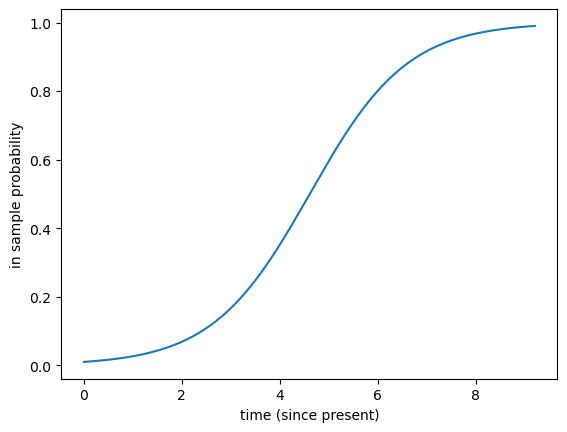

In [42]:
ts = np.arange(0,t,dt)
Es = np.zeros(ts.shape)

Es[0] = 1 - rho0
for i in range(1,len(ts)):
    Es[i] = Es[i-1] + dt*λ*(Es[i-1]**2-Es[i-1])
    
plt.plot(ts,1-Es);
plt.ylabel("in sample probability");
plt.xlabel("time (since present)");

In [43]:
def Efnc(t):
    return np.interp(t,ts,Es)

def modulation(λ, x, t):
    # return λ 
    return λ * (1-Efnc(t))

In [44]:
birth_rate_modulated = poisson.ModulatedRateResponse(
    poisson.ConstantResponse(λ),
    modulation
)
birth_rate_base = poisson.ConstantResponse(λ)
death_rate = poisson.ConstantResponse(0.0)
mutation_rate = poisson.ConstantResponse(0.0)

In [45]:
mutator = mutators.DiscreteMutator(state_space=[0],transition_matrix=np.matrix([1]))

In [46]:
%%time

# modulated simulation
tip_counts_modulated = []
times_modulated = []
error_seeds_modulated = []
for i in range(1):
    rng = np.random.default_rng(seed=i)
    try:
        start_time = time.time()
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            t,
            birth_response=birth_rate_modulated,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=1,
            capacity=10000,
            birth_mutations=False,
            seed=rng,
        )
        times_modulated = times_modulated + [time.time() - start_time]
        print(f"try {i + 1} succeeded, tip count: {len(tree)}",end="\r")
        tip_counts_modulated = tip_counts_modulated + [len(tree)]
    except:
        error_seeds_modulated = error_seeds_modulated + [i]
        continue

In [ ]:
%%time

# full simulation
tip_counts_pruned = []
tip_counts_full = []
times_base = []
error_seeds_base = []
for i in range(50):
    rng = np.random.default_rng(seed=i)
    try:
        start_time = time.time()
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            t,
            birth_response=birth_rate_base,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=1,
            capacity=10000,
            birth_mutations=False,
            seed=rng,
        )
        tip_counts_full = tip_counts_full + [len(tree)]
        tree.sample_survivors(p=rho0)
        tree.prune()
        print(f"try {i + 1} succeeded, tip count: {len(tree)}",end="\r")
        tip_counts_pruned = tip_counts_pruned + [len(tree)]
        times_base = times_base + [time.time() - start_time]
    except:
        error_seeds_base = error_seeds_base + [i]
        continue